In [1]:
import os
import ntpath

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib

import cv2
import pandas as pd
import random

In [2]:
datadir = "lesson14_recording_2"
columns = [ 'center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed' ]
data = pd.read_csv( os.path.join( datadir, 'images.csv' ), names = columns )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,12.76234
1,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,13.37253
2,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,14.22138
3,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,15.02460
4,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,15.40608


In [3]:
def path_leaf( path ):
    head, tail = ntpath.split( path )
    return tail

data[ 'center' ] = data[ 'center' ].apply( path_leaf )
data[ 'left' ] = data[ 'left' ].apply( path_leaf )
data[ 'right' ] = data[ 'right' ].apply( path_leaf )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_17_23_36_29_938.jpg,left_2020_11_17_23_36_29_938.jpg,right_2020_11_17_23_36_29_938.jpg,0.0,1.0,0.0,12.76234
1,center_2020_11_17_23_36_30_006.jpg,left_2020_11_17_23_36_30_006.jpg,right_2020_11_17_23_36_30_006.jpg,0.0,1.0,0.0,13.37253
2,center_2020_11_17_23_36_30_074.jpg,left_2020_11_17_23_36_30_074.jpg,right_2020_11_17_23_36_30_074.jpg,0.0,1.0,0.0,14.22138
3,center_2020_11_17_23_36_30_141.jpg,left_2020_11_17_23_36_30_141.jpg,right_2020_11_17_23_36_30_141.jpg,0.0,1.0,0.0,15.02460
4,center_2020_11_17_23_36_30_210.jpg,left_2020_11_17_23_36_30_210.jpg,right_2020_11_17_23_36_30_210.jpg,0.0,1.0,0.0,15.40608


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


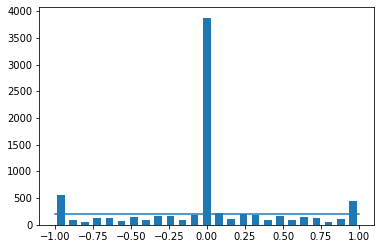

In [4]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram( data[ 'steering' ], num_bins )
center = ( bins[ : -1 ] + bins[ 1: ] ) * 0.5
print( bins )
plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

total data:  7677
removed:  4293
remaining:  3384


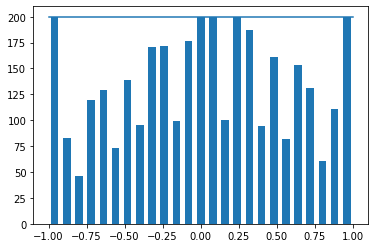

In [5]:
print( 'total data: ', len ( data ) )
remove_list = []
for j in range( num_bins ):
    list_ = []
    for i in range( len ( data[ 'steering' ] ) ):
        if data[ 'steering' ][ i ] >= bins[ j ] and data[ 'steering' ][ i ] <= bins[ j + 1 ]:
            list_.append( i )
    list_ = shuffle( list_ )
    list_ = list_[ samples_per_bin: ]
    remove_list.extend( list_ )

print( 'removed: ', len( remove_list ) )
data.drop( data.index[ remove_list ], inplace = True )
print( 'remaining: ', len( data ) )

hist, _ = np.histogram( data[ 'steering' ], ( num_bins ) )

plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

In [6]:
print( data.iloc[ 1 ] )
def load_img_steering( datadir, df ):
    image_path = []
    steering = []
    for i in range( len( data ) ):
        indexed_data = data.iloc[ i ]
        center, left, right = indexed_data[ 0 ], indexed_data[ 1 ], indexed_data[ 2 ]
        image_path.append( os.path.join( datadir, center.strip() ) )
        steering.append( float( indexed_data[ 3 ] ) )
    image_paths = np.asarray( image_path )
    steerings = np.asarray( steering )
    return image_paths, steerings

image_paths, steerings = load_img_steering( datadir + '/IMG', data )

center      center_2020_11_17_23_36_31_653.jpg
left          left_2020_11_17_23_36_31_653.jpg
right        right_2020_11_17_23_36_31_653.jpg
steering                                     0
throttle                                     1
reverse                                      0
speed                                  29.7478
Name: 24, dtype: object


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steerings, test_size = 0.2, random_state = 87 )
print( 'Training Samples: {}\nValid Samples: {}'.format( len( X_train ), len( X_valid ) ))

Training Samples: 2707
Valid Samples: 677


Text(0.5, 1.0, 'Training set')

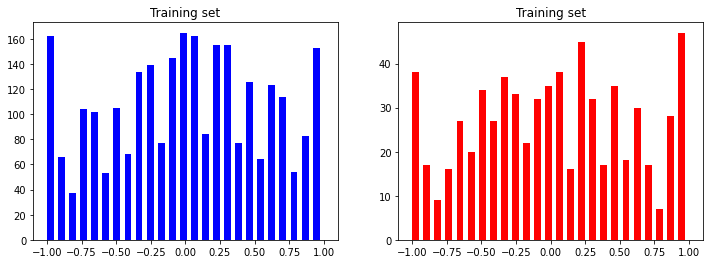

In [8]:
fig, axes = plt.subplots( 1, 2, figsize=( 12, 4 ) )
axes[ 0 ].hist( y_train, bins = num_bins, width = 0.05, color = 'blue' )
axes[ 0 ].set_title('Training set')
axes[ 1 ].hist( y_valid, bins = num_bins, width = 0.05, color = 'red' )
axes[ 1 ].set_title('Training set')

In [9]:
def img_preprocess( img_path ):
    img = mpimg.imread( img_path )
    img = img[ 60:135, :, : ]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
    img = cv2.resize( img, ( 200, 66 ) )
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

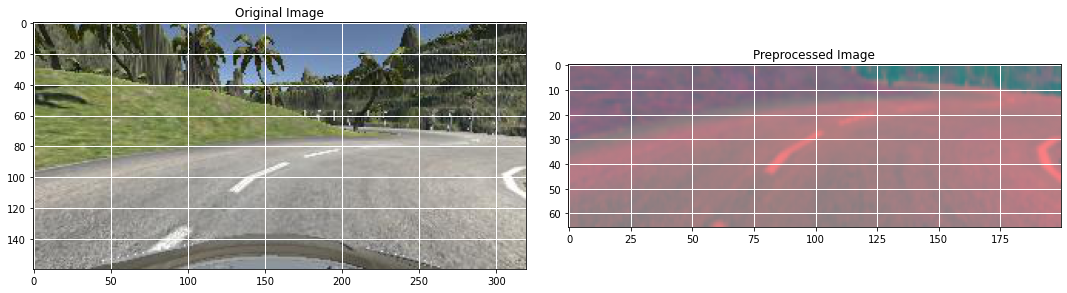

In [10]:
img_path = image_paths[ 100 ]
img_original = mpimg.imread( img_path )
img_preprocessed = img_preprocess( img_path )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )
axs[ 1 ].imshow( img_preprocessed )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Preprocessed Image' )

(2707, 66, 200, 3)


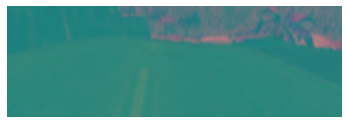

In [11]:
X_train_pp = np.array( list( map( img_preprocess, X_train ) ) )
X_valid_pp = np.array( list( map( img_preprocess, X_valid ) ) )

plt.imshow( X_train_pp[ random.randint( 0, len( X_train_pp ) - 1 ) ] )
plt.axis( 'off' )
print( X_train_pp.shape )

In [12]:
def nvidia_model():
    model = Sequential()
    model.add( Convolution2D( 24, 5, 2, input_shape = ( 66, 200, 3 ), activation = 'elu' ) )
    model.add( Convolution2D( 36, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 48, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Flatten() )
    model.add( Dense( 100, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 50, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 10, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense(1) )

    model.compile( Adam( lr = 1e-3 ), loss = 'mse' )
    return model

In [13]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [14]:
#history = model.fit( X_train_flat, y_train_flat, epochs = 20,  validation_data = ( X_val_flat, y_val_flat), batch_size = 400, verbose = 1, shuffle = 1)
history = model.fit( X_train_pp, y_train, epochs = 30, validation_data = ( X_valid_pp, y_valid ), batch_size = 100, verbose = 1, shuffle = 1 )

Epoch 1/30
28/28 [==============================] - 2s 34ms/step - loss: 1.3464 - val_loss: 0.2240
Epoch 2/30
28/28 [==============================] - 1s 21ms/step - loss: 0.2303 - val_loss: 0.2011
Epoch 3/30
28/28 [==============================] - 1s 21ms/step - loss: 0.1992 - val_loss: 0.1879
Epoch 4/30
28/28 [==============================] - 1s 19ms/step - loss: 0.1965 - val_loss: 0.1674
Epoch 5/30
28/28 [==============================] - 1s 22ms/step - loss: 0.1742 - val_loss: 0.1768
Epoch 6/30
28/28 [==============================] - 1s 20ms/step - loss: 0.1785 - val_loss: 0.1670
Epoch 7/30
28/28 [==============================] - 1s 20ms/step - loss: 0.1783 - val_loss: 0.3852
Epoch 8/30
28/28 [==============================] - 1s 20ms/step - loss: 0.2362 - val_loss: 0.1759
Epoch 9/30
28/28 [==============================] - 1s 20ms/step - loss: 0.1874 - val_loss: 0.1546
Epoch 10/30
28/28 [==============================] - 1s 20ms/step - loss: 0.1623 - val_loss: 0.1528
Epoch 11/

Text(0.5, 0, 'Epoch')

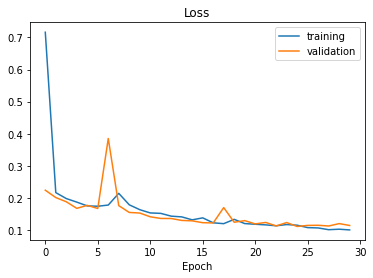

In [15]:
plt.plot( history.history[ 'loss' ] )
plt.plot( history.history[ 'val_loss' ] )
plt.legend( [ 'training', 'validation' ] )
plt.title( 'Loss' )
plt.xlabel( 'Epoch' )

In [16]:
model.save( 'model2.h5' )